### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [67]:
def display_head_diff(cache,cache2, labels, layer, head, show=True):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]-cache2[f"blocks.{layer}.attn.hook_pattern"]
    last_idx = average_patterns.shape[-1] - 1
    while labels[last_idx] == ",":
        last_idx -= 1
    last_idx += 1
    matrix = average_patterns[0, head, :last_idx, :last_idx].cpu()
    labels = labels[:last_idx]
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)
    if show:
        fig.show()
    else:
        return fig

### Model Training

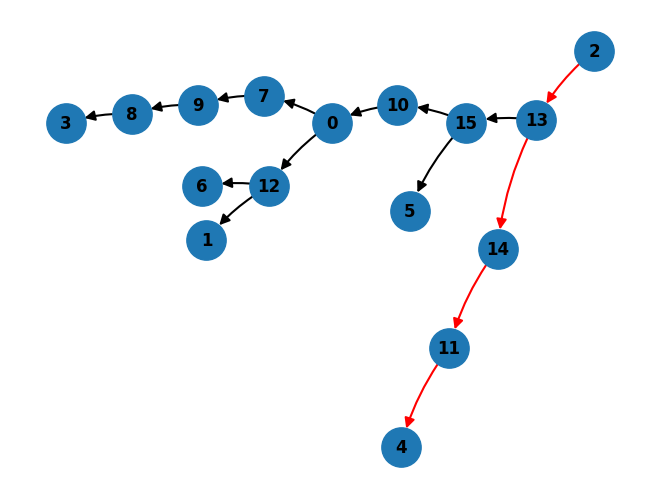

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [40]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)
model_modified = HookedTransformer(cfg)

In [4]:
model_name="model.pt"

In [42]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [14]:
for key,value in  model.state_dict().items():
    print(key)

embed.W_E
pos_embed.W_pos
blocks.0.ln1.w
blocks.0.ln1.b
blocks.0.ln2.w
blocks.0.ln2.b
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.b_O
blocks.0.attn.mask
blocks.0.attn.IGNORE
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
blocks.1.ln1.w
blocks.1.ln1.b
blocks.1.ln2.w
blocks.1.ln2.b
blocks.1.attn.W_Q
blocks.1.attn.W_K
blocks.1.attn.W_V
blocks.1.attn.W_O
blocks.1.attn.b_Q
blocks.1.attn.b_K
blocks.1.attn.b_V
blocks.1.attn.b_O
blocks.1.attn.mask
blocks.1.attn.IGNORE
blocks.1.mlp.W_in
blocks.1.mlp.b_in
blocks.1.mlp.W_out
blocks.1.mlp.b_out
blocks.2.ln1.w
blocks.2.ln1.b
blocks.2.ln2.w
blocks.2.ln2.b
blocks.2.attn.W_Q
blocks.2.attn.W_K
blocks.2.attn.W_V
blocks.2.attn.W_O
blocks.2.attn.b_Q
blocks.2.attn.b_K
blocks.2.attn.b_V
blocks.2.attn.b_O
blocks.2.attn.mask
blocks.2.attn.IGNORE
blocks.2.mlp.W_in
blocks.2.mlp.b_in
blocks.2.mlp.W_out
blocks.2.mlp.b_out
blocks.3.ln1.w
block

In [80]:
new_dict = {}

for key, value in model.state_dict().items():
    if key.startswith("blocks.4"):
        new_key = "blocks.1" + key[8:]#add more for more digits
        new_dict[key] = model.state_dict()[new_key] 
    else:
        new_dict[key] = value
model_modified.load_state_dict(new_dict)

<All keys matched successfully>

In [81]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model_modified, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 97.0000%
backward: 72.0000%
random: 88.0000%


In [68]:
test_graph = generate_example(n_states, 5, order="random")
labels, test_cache = get_example_cache(test_graph, model, dataset)
labels, test_cache_modified = get_example_cache(test_graph, model_modified, dataset)

In [69]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head_diff(test_cache,test_cache_modified, labels, l, h, show=True)

In [7]:
acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[],
        n_states=n_states,
        n_samples=5000,
        min_path_length=8
    )

KeyboardInterrupt: 

In [ ]:
#test_graph = generate_example(n_states, 5, order="random")
test_graph=graphs[0]
labels, test_cache = get_example_cache(test_graph, model, dataset)


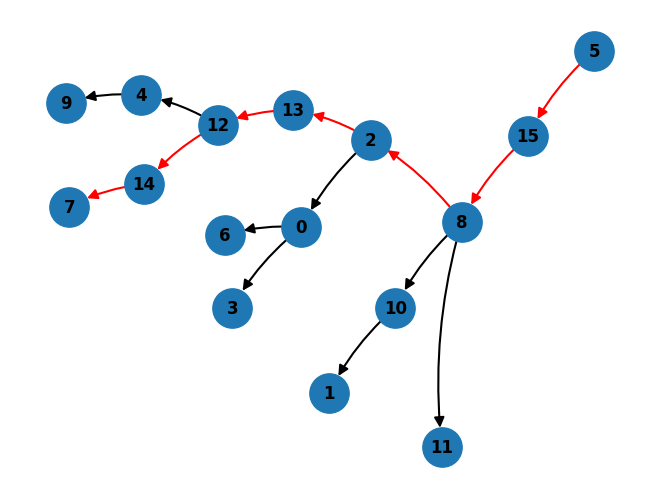

In [ ]:
parse_example(test_graph)

In [ ]:
labels, cache = get_example_cache(test_graph, model, dataset)

In [ ]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

In [ ]:
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:
model.reset_hooks()